Task statement:

Multi-class классификация.
Рекуррентные и свёрточные нейрононные сети и embeddings для работы с текстом.

Датасет - Руcскоязычные отзывы с оценками.

Метрика - f1-score, weighted.

Задачи:

- Обучить линейную модель на TF-IDF представлении для предсказания оценки пользователя по его отзыву. Посмотреть на важность для каждой оценки.
- Обучить рекуррентную нейронную сеть для предсказания оценки пользователя по его отзыву. Использовать случайную инициализация весов.
- Обучить «fasttext» модель на n-граммах используя случайную инициализацию эмбедингов. 
- Обучить сharacter based модель (вместо слов мы подаём предложение посимвольно). 
    Заимплементить самому, либо нагуглить готовые имплементации.
- Опционально (for honor): Обучить модель из примера имплементации ниже, но с использованием уже предобученного word2vec для русского языка. в качестве инициализации эмбединга.


In [1]:
#update libs in colab
!pip install --upgrade pandas
!pip install --upgrade scikit-learn
!pip install --upgrade seaborn
!pip install --upgrade tensorflow
!pip install --upgrade pymystem3
!pip install --upgrade requests
!pip install --upgrade gensim
!pip install --upgrade imblearn

Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (0.24.1)
Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.20.2)
Requirement already up-to-date: seaborn in /usr/local/lib/python3.6/dist-packages (0.9.0)
Requirement already up-to-date: pprint in /usr/local/lib/python3.6/dist-packages (0.1)
Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (1.13.0rc1)
Requirement already up-to-date: pymystem3 in /usr/local/lib/python3.6/dist-packages (0.2.0)
Requirement already up-to-date: requests in /usr/local/lib/python3.6/dist-packages (2.21.0)
Requirement already up-to-date: gensim in /usr/local/lib/python3.6/dist-packages (3.7.1)
Requirement already up-to-date: imblearn in /usr/local/lib/python3.6/dist-packages (0.0)


In [2]:
# to load/save models
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#common libs
import numpy as np
import pandas as pd
import scipy.stats as st
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font_scale=1.3)

import re
import string
import itertools
from tqdm import tqdm
from time import time
from collections import Counter

import pickle
import os 
import sys

seed = 321

%matplotlib inline

In [0]:
#sklearn libs
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline,Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report,f1_score, make_scorer

from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.utils import shuffle

from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.under_sampling import RandomUnderSampler

#part 5 libs
import gensim
import requests
from pymystem3 import Mystem

In [0]:
import tensorflow as tf

import keras
import json
import operator
from keras.preprocessing import sequence
from keras.models import Sequential, model_from_json,load_model
from keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Bidirectional 
from keras.layers import GlobalAveragePooling1D,Flatten,BatchNormalization, Input, GlobalMaxPooling1D, Conv1D, MaxPooling1D 
from keras.metrics import binary_accuracy,categorical_accuracy
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras import backend as K 

from keras.utils import np_utils

#convert words to sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#from keras.datasets import imdb

In [6]:
import nltk
nltk.download('punkt')
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('names')

from nltk.corpus import names
from nltk.corpus import stopwords
from nltk import ngrams

from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer # one more stemmer? or lemmatisation
from nltk.stem import WordNetLemmatizer,LancasterStemmer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!


In [0]:
# temp function to get rundom n samples from dataset
def next_batch(num, data, labels):
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = data[idx]
    labels_shuffle = [labels[i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

#### EDA.

Считаем данные и выведем несколько образцов.

In [0]:
x_data, y_data = pickle.load(open('drive/My Drive/data/reviews_dataset.pkl', 'rb'))

In [9]:
len(x_data)

769251

In [10]:
len(y_data)

769251

In [11]:
x_data[0]

'Потрясающе красивая графика космоса! Уже за это игру можно полюбить. Так же в наличии интересный осмысленный сюжет и удобное управление.'

In [12]:
y_data[0]

5

In [250]:
x_data[33]

'Купил. Очень нравится. Пока нареканий нет никаких. Всегда очень нравились телефоны - слайдеры у Сименса, но у них не было BlueToth-а:(Наконец Simens сделал слайдер с с BlueTooth!'

In [251]:
y_data[33]

5

In [249]:
Counter(y_data)

Counter({1: 55327, 2: 32362, 3: 59226, 4: 110665, 5: 511671})

Похоже, положительные отзывы (4 и 5) превалируют над остальными классами.

Т.к. данных сравнительно много, попробуем использовать UnderSampling, для того, чтобы в обучающем наборе получить тексты всех классов.

#### Baseline.

Обучить линейную модель на TF-IDF представлении для предсказания оценки пользователя по его отзыву. 

Посмотреть на важность для каждой оценки.

Воспользуемся токенайзером для очистки и подготовки текстов.

Это поможет в будущем, при обучении алгоритмов + tokenizer от Keras не обладает функционалом отсечения стоп слов и лемматизации.

In [0]:
def remove_emails(text):
    text = re.sub(r'\S*@\S*\s?','',text)    
    return text


#version on raw text
def remove_punctuation2(text_punctuation,text):
    
    new_text = []
    new_text = re.sub('\n', ' ',text)
    new_text = re.sub('\t', '',new_text)
    new_text = re.sub('['+text_punctuation+']', ' ',new_text)
    new_text =  new_text.strip()
    
    return new_text

#version after word_tokenizer
def remove_punctuation(text_punctuation,text):
    
    new_text = []
    for word in text: 
        new_word =  re.sub('['+text_punctuation+']', ' ',word)
        new_word =  new_word.strip()
        new_text.append(new_word)
    
    return new_text


#ntlk word lemmatizer
def lemmatize_stemm_text(text):
    new_text_lemma = []
    new_text_stemm = []
    
    lemmatizer = WordNetLemmatizer()
    stemmer = LancasterStemmer()
    
    for word in text:
        lemma = lemmatizer.lemmatize(word, pos='n') # v default
        new_text_lemma.append(lemma)
        
        #stemm = stemmer.stem(word)
        #new_text_stemm.append(stemm)
        
    return new_text_lemma, new_text_stemm
        

StopWords = list(set(stopwords.words('russian')))
StopWords.remove('не')


def remove_stopwords(stop_words ,text):
    
    new_words = []
    for word in text:
        if word not in stop_words:
            new_words.append(word)

    return new_words

def remove_short_words(text, word_len):
    new_text = []
    for word in text:
        if len(word) >= word_len:
            new_text.append(word)
            
    return new_text


# getting source from string.punctuation
text_punctuation = '!"#$%&\'()*+,-.:;<=>?@[\\]_`{|}~/^'

def tokenize(text):
    min_length = 3
    
    # remove emails from text to prevent overfit
    text = remove_emails(text)
    
    # text to lowercase
    text =  text.lower()

    
    #remove punctuation
    text = remove_punctuation2(text_punctuation, text) 

    # tokenize text
    words = word_tokenize(text,language='english')

       
    # remove stopwords
    words = remove_stopwords(StopWords,words)
    
    #lemmatize words ,improve to 0.69 f1score
    words,_ = lemmatize_stemm_text(words)
    
    #filter short words
    words = remove_short_words(words, 2) #default 3

    return words

In [14]:
%%time
test = tokenize(x_data[4])

CPU times: user 2.18 s, sys: 111 ms, total: 2.29 s
Wall time: 2.3 s


In [15]:
test

['таки',
 'не',
 'удержался',
 'написать',
 'топ',
 'скорей',
 'сотрут',
 'прочтет',
 'ужасной',
 'игры',
 'star',
 'war',
 'empire',
 'at',
 'war',
 'dvd',
 'ещё',
 'поискать',
 'нормального',
 'сюжета',
 'стратегия',
 'это',
 'вовсе',
 'провал',
 'давно',
 'убедился',
 'всё',
 'берётся',
 '1с',
 'плане',
 'игр',
 'отстой',
 'хорошая',
 'стратегия',
 'эпизодам',
 'star',
 'war',
 'это',
 'star',
 'war',
 'galactic',
 'battleground',
 'играл',
 'поймет']

Датасет достаточно объемный, поэтому в целях экономии времени:
- возьмем часть от него
- "токенизируем"
- поделим его еще раз на трейн-тест
- используем RandomUnderSampling

In [0]:
# get first part with stratify
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, random_state = seed, test_size=0.8, shuffle=True, stratify = y_data)

In [17]:
# tokenize
x_data_tokenized = []
for text in tqdm(x_train):
    tokenized_text = ' '.join(tokenize(text))
    x_data_tokenized.append(tokenized_text)

100%|██████████| 153850/153850 [01:24<00:00, 1829.08it/s]


In [0]:
# split train and test
x_train, x_test, y_train, y_test = train_test_split(x_data_tokenized, y_train, random_state = seed, 
                                                    test_size=0.3, shuffle=True, stratify = y_train)


In [19]:
len(x_train)

107695

In [20]:
len(x_test)

46155

Undersample data, to make good set for learning.

In [21]:
n5 = Counter(y_train)[5] // 6 #the biggest class
n4 = Counter(y_train)[4] // 2 #second biggest class
n3 = Counter(y_train)[3] // 1
n2 = Counter(y_train)[2] // 1
n1 = Counter(y_train)[1] // 1

sum_n = np.sum([n5 , n4 , n3 , n2 , n1])
print (n5,n4,n3,n2,n1, "sum :" + str(sum_n)) # ratio we want

print(Counter(y_train), len (y_train)) # original data

11939 7746 8292 4531 7745 sum :40253
Counter({5: 71634, 4: 15493, 3: 8292, 1: 7745, 2: 4531}) 107695


In [0]:
x_train = np.reshape(x_train, (-1, 1)) #need numpy reshape for imblearn randomundersampler

In [0]:
rus = RandomUnderSampler(random_state=seed,ratio={1: n1, 2: n2, 3: n3, 4: n4,5: n5})
x_train, y_train = rus.fit_resample(x_train, y_train)

In [24]:
print(Counter(y_train))
x_train = np.array(x_train).tolist()

print (len(x_train))
print (len(y_train))

#reshuffle it
#because data is sorted after under sampling
x_train, y_train = shuffle(x_train, y_train, random_state=seed)

Counter({5: 11939, 3: 8292, 4: 7746, 1: 7745, 2: 4531})
40253
40253


same idea for test, but here we just divide all targets by 4, to reduce array size.

In [25]:
n5 = Counter(y_test)[5] // 4
n4 = Counter(y_test)[4] // 4
n3 = Counter(y_test)[3] // 4
n2 = Counter(y_test)[2] // 4
n1 = Counter(y_test)[1] // 4

sum_n = np.sum([n5 , n4 , n3 , n2 , n1])
print (n5,n4,n3,n2,n1, "sum :" + str(sum_n))

print(Counter(y_test), len (y_test))

7675 1660 888 485 830 sum :11538
Counter({5: 30700, 4: 6640, 3: 3553, 1: 3320, 2: 1942}) 46155


In [0]:
x_test = np.reshape(x_test, (-1, 1))

In [0]:
rus = RandomUnderSampler(random_state=seed,ratio={1: n1, 2: n2, 3: n3, 4: n4,5: n5})
x_test, y_test = rus.fit_resample(x_test, y_test)

In [28]:
print(Counter(y_test))
x_test = np.array(x_test).tolist()

print (len(x_test))
print (len(y_test))

#reshuffle it
x_test, y_test = shuffle(x_test, y_test, random_state=seed)

Counter({5: 7675, 4: 1660, 3: 888, 1: 830, 2: 485})
11538
11538


In [0]:
#back to list of strings, for correct work of tokenizers
x_train = [item for sublist in x_train for item in sublist]
x_test = [item for sublist in x_test for item in sublist]

dump preprocessed train/test split.

In [0]:
path = "drive/My Drive/data/models/task3_data_preprocessed/"
with open(path + "tmp.pickle", "wb") as f:
    pickle.dump((x_train,x_test,y_train,y_test), f)

In [0]:
path = "drive/My Drive/data/models/task3_data_preprocessed/"
with open(path + "tmp.pickle", "rb") as f:
    x_train,x_test,y_train,y_test = pickle.load(f)

In [0]:
#clean garbage    
del x_data_tokenized, x_data, y_data , path  

#### TFIDF + LogisticRegression.

In [0]:
vectorizer = TfidfVectorizer(stop_words=StopWords,
                             tokenizer=None, 
                             min_df=4, # ignore terms with freq less that т, lower majoring 4
                             max_df=0.8, # ignore terms with freq more that n, upper majoring 0.8
                             use_idf=True,  
                             sublinear_tf=True,
                             norm='l2',
                             lowercase = False                           
                            )

In [45]:
%%time
vectorised_train_documents = vectorizer.fit_transform(x_train)
vectorised_test_documents = vectorizer.transform(x_test)

CPU times: user 2.58 s, sys: 28.3 ms, total: 2.61 s
Wall time: 2.63 s


In [46]:
vectorised_train_documents.shape

(40253, 29515)

In [47]:
vectorised_test_documents.shape

(11538, 29515)

In [0]:
def classify_and_score(classifier, X_train, X_test, y_train, y_test):
    clf = classifier
    clf.fit(X_train, y_train)

    pred_train = clf.predict(X_train)
    #print ("Train score")
    f1_train = f1_score(y_train, pred_train, average='weighted')

    #print ("Test score")
    pred_test = clf.predict(X_test)
    f1_test = f1_score(y_test, pred_test, average='weighted')
    
    return f1_train, f1_test, clf

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Paired):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [0]:
log_reg = LogisticRegression(penalty='l2', tol=0.0001, C=1, 
                             class_weight='balanced', random_state=seed, 
                             max_iter=1000, solver = 'newton-cg',
                             multi_class='ovr', verbose=0, 
                             n_jobs=-1)

In [50]:
%%time
_,_, clf = classify_and_score(log_reg, vectorised_train_documents, 
                           vectorised_test_documents, y_train, y_test)

CPU times: user 86.2 ms, sys: 315 ms, total: 401 ms
Wall time: 9.45 s


              precision    recall  f1-score   support

           1       0.37      0.54      0.44       830
           2       0.14      0.22      0.17       485
           3       0.21      0.36      0.26       888
           4       0.28      0.34      0.31      1660
           5       0.89      0.69      0.77      7675

   micro avg       0.58      0.58      0.58     11538
   macro avg       0.38      0.43      0.39     11538
weighted avg       0.68      0.58      0.62     11538

Confusion matrix, without normalization
None


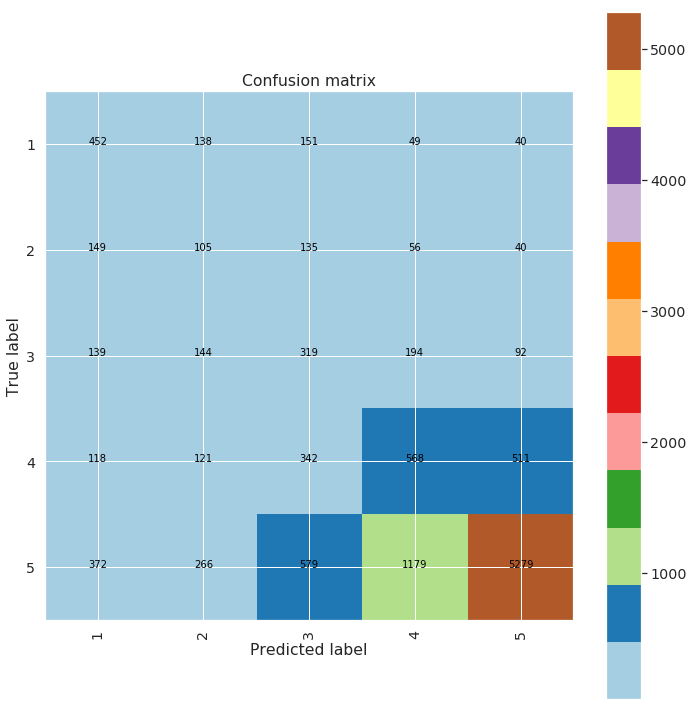

In [51]:
labels = clf.classes_
pred_test = clf.predict(vectorised_test_documents)
print(classification_report(y_test,pred_test,labels = labels))

cnf_matrix = confusion_matrix(y_test, pred_test)
print(plot_confusion_matrix(cnf_matrix, classes = labels))

Лучше всего классифицируется класс 5, т.к. его больше всего в тестовых данных.

Также стоит отметить классы 1 и 3, они содержат примерно одинаковое количество записей, при этом:
Класс 1 сравнительно неплохо классифицировался, при этом класс 3 классифицировался значительно хуже, и он похоже сливается с другими классами (2 и 4), судя по confusion matrix.

В целом алгоритм отработал средне, скорее всего если его обучить на всех данных и подобрать гиперпараметры, то результат изменится в лучшую сторону.

#### RNN.
Обучить рекуррентную нейронную сеть для предсказания оценки пользователя по его отзыву. Использовать случайную инициализация весов.

In [0]:
K.clear_session()

In [0]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
encoded_y_test = encoder.transform(y_test)

# convert integers to dummy variables (i.e. one hot encoded)
y_train = np_utils.to_categorical(encoded_y_train)
y_test = np_utils.to_categorical(encoded_y_test)

In [0]:
# Set parameters
num_word = 35000
batch_size = 128
embedding_dims = 128
epochs = 5
maxlen = 40
task2_filepath = 'drive/My Drive/data/models/subtask2/'

In [278]:
#tokenize data, 
%%time
tokenizer = Tokenizer(num_words=num_word)
tokenizer.fit_on_texts(x_train)

x_train_tokenized = tokenizer.texts_to_sequences(x_train)
x_test_tokenized  = tokenizer.texts_to_sequences(x_test)

CPU times: user 9.53 s, sys: 191 ms, total: 9.72 s
Wall time: 9.72 s


In [279]:
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
print (vocab_size)

127404


In [282]:
print('Average train sequence length: {}'.format(
        np.mean(list(map(len, x_train_tokenized)), dtype=int)))
print('Average test sequence length: {}'.format(
        np.mean(list(map(len, x_test_tokenized)), dtype=int)))

Average train sequence length: 40
Average test sequence length: 40


In [281]:
%%time
x_train_tokenized = pad_sequences(x_train_tokenized, padding='post', maxlen=maxlen)
x_test_tokenized = pad_sequences(x_test_tokenized, padding='post', maxlen=maxlen)

CPU times: user 317 ms, sys: 1.96 ms, total: 319 ms
Wall time: 319 ms


In [92]:
vocab_size * 128 # params of first layer, 128 is number of embeddings or num_word

16307712

In [283]:
#случайную инициализация весов
model = Sequential()
model.add(Embedding(input_dim = num_word, output_dim = 128,  #vocab_size
                    input_length=maxlen))#
model.add(Bidirectional(LSTM(64),weights = 'glorot_uniform'))# weights!
model.add(Dropout(0.6))
model.add(Dense(5, activation='softmax')) #softmax due to multiclass

# try using different optimizers and different optimizer configs
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 40, 128)           4480000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 645       
Total params: 4,579,461
Trainable params: 4,579,461
Non-trainable params: 0
_________________________________________________________________


In [0]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=3, 
                              verbose=1, min_delta=0.01,
                              mode='min',restore_best_weights=True)


checkpoint = ModelCheckpoint(task2_filepath + 'baseline_model.hdf5', monitor='val_loss', 
                             verbose=1, save_best_only=True, mode='min')

m_callbacks = [checkpoint, earlyStopping]

In [0]:
'''# no stratify
x_train_part,y_train_part = next_batch(40000, x_train_tokenized, y_train)
x_test_part,y_test_part = next_batch(10000, x_test_tokenized, y_test)

%%time
print('Train...')
history_model = model.fit(x_train_part, y_train_part,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 1,
          callbacks=m_callbacks,
          validation_data=[x_test_part, y_test_part])

''';

In [286]:
%%time
print('Train...')
history_model = model.fit(x_train_tokenized, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 1,
          callbacks=m_callbacks,
          validation_data=[x_test_tokenized, y_test])

Train...
Train on 40253 samples, validate on 11538 samples
Epoch 1/5
40253/40253 [==============================] - 111s 3ms/step - loss: 1.3803 - acc: 0.4075 - val_loss: 1.0189 - val_acc: 0.6177

Epoch 00001: val_loss improved from inf to 1.01892, saving model to drive/My Drive/data/models/subtask2/baseline_model.hdf5
Epoch 2/5
40253/40253 [==============================] - 105s 3ms/step - loss: 1.0806 - acc: 0.5630 - val_loss: 1.0038 - val_acc: 0.6102

Epoch 00002: val_loss improved from 1.01892 to 1.00377, saving model to drive/My Drive/data/models/subtask2/baseline_model.hdf5
Epoch 3/5
40253/40253 [==============================] - 106s 3ms/step - loss: 0.8620 - acc: 0.6638 - val_loss: 1.1971 - val_acc: 0.5740

Epoch 00003: val_loss did not improve from 1.00377
Epoch 4/5
40253/40253 [==============================] - 105s 3ms/step - loss: 0.6647 - acc: 0.7507 - val_loss: 1.4859 - val_acc: 0.5166

Epoch 00004: val_loss did not improve from 1.00377
Epoch 5/5
40253/40253 [============

In [0]:
'''# serialize model to JSON
model_json = model.to_json()
with open(path + "model" + ".json", "w") as json_file:
    json_file.write(model_json)''';

with open(task2_filepath + "history"+ ".json", 'w') as f:
    json.dump(history_model.history, f)
    
'''# serialize weights to HDF5
model.save_weights(path + "model" +  ".h5")
print("Saved model to disk")''';

In [0]:
#load history
json_file = open(task2_filepath + "history"+ ".json", 'r')
loaded_history_json = json.load(json_file)
json_file.close()

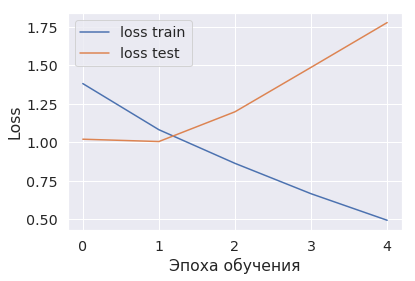

In [289]:
plt.plot(loaded_history_json['loss'], 
         label='loss train')
plt.plot(loaded_history_json['val_loss'], 
         label='loss test')
plt.xlabel('Эпоха обучения')
plt.ylabel('Loss')
plt.legend()
plt.show()

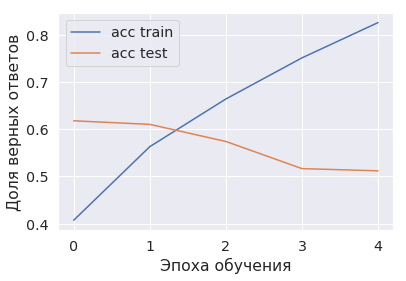

In [290]:
plt.plot(loaded_history_json['acc'], 
         label='acc train')
plt.plot(loaded_history_json['val_acc'], 
         label='acc test')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [0]:
loaded_model = Sequential() #?
loaded_model = load_model(task2_filepath + 'baseline_model.hdf5')

In [292]:
y_predicted_scores = loaded_model.predict(x_test_tokenized)
y_predicted_scores[y_predicted_scores>=0.5] = 1
y_predicted_scores[y_predicted_scores<0.5] = 0

print('Classification report\n')
print(classification_report(y_test, y_predicted_scores))

Classification report

              precision    recall  f1-score   support

           0       0.58      0.32      0.41       830
           1       0.00      0.00      0.00       485
           2       0.37      0.09      0.14       888
           3       0.36      0.12      0.18      1660
           4       0.89      0.63      0.74      7675

   micro avg       0.81      0.46      0.59     11538
   macro avg       0.44      0.23      0.29     11538
weighted avg       0.72      0.46      0.56     11538
 samples avg       0.46      0.46      0.46     11538



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [0]:
reverse_y_test = np.argmax(y_test, axis=1)
reverse_y_pred = np.argmax(y_predicted_scores, axis=1)

In [294]:
Counter(reverse_y_test)

Counter({0: 830, 1: 485, 2: 888, 3: 1660, 4: 7675})

In [295]:
Counter(reverse_y_pred)

Counter({0: 5374, 2: 215, 3: 580, 4: 5369})

Confusion matrix, without normalization
None


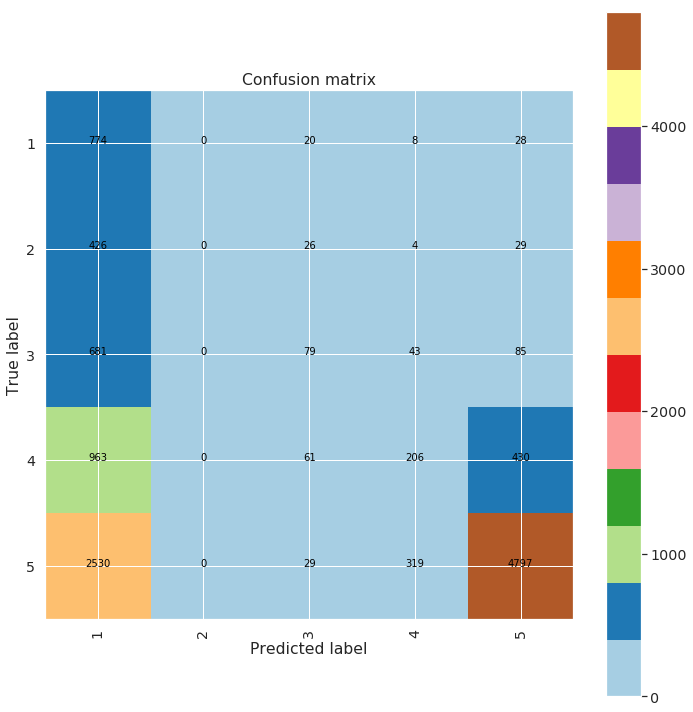

In [297]:
labels = [1,2,3,4,5]
cnf_matrix = confusion_matrix(reverse_y_test, reverse_y_pred)
print(plot_confusion_matrix(cnf_matrix, classes = labels))

Исходя из репорта видно, что:
- отзывы с оценками 2 и 3 классифицуются хуже всего.
- отзывы на 5 классифицируются достаточно неплохо, но не стоит забывать, что их больше всего и возможно сети на них легче всего выучиться (несмотря на то, что их и подрезали при помощи UnderSampling'a).
- достаточно много отзывов, классифицируемых как 1, хотя скорее всего так происходит, потому, что на этот класс приходятся, в большинстве своем, missclasified отзывы.

#### fasttext.

Обучить «fasttext» модель на n-граммах используя случайную инициализацию эмбедингов.

In [0]:
K.clear_session()

In [0]:
# Set parameters:
# ngram_range = 2 will add bi-grams features
ngram_range = 2
max_features = 20000
maxlen = 80
batch_size = 128
embedding_dims = 64
epochs = 5
task3_filepath = "drive/My Drive/data/models/subtask3/"

In [165]:
%%time
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)

x_train_tokenized = tokenizer.texts_to_sequences(x_train)
x_test_tokenized  = tokenizer.texts_to_sequences(x_test)

CPU times: user 6.22 s, sys: 99 ms, total: 6.32 s
Wall time: 6.32 s


In [166]:
print('Average train sequence length: {}'.format(
        np.mean(list(map(len, x_train_tokenized)), dtype=int)))
print('Average test sequence length: {}'.format(
        np.mean(list(map(len, x_test_tokenized)), dtype=int)))

Average train sequence length: 21
Average test sequence length: 20


In [0]:
def create_ngram_set(input_list, ngram_value=2):
    """
    Extract a set of n-grams from a list of integers.
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=2)
    {(4, 9), (4, 1), (1, 4), (9, 4)}
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=3)
    [(1, 4, 9), (4, 9, 4), (9, 4, 1), (4, 1, 4)]
    """
    return set(zip(*[input_list[i:] for i in range(ngram_value)]))

In [0]:
def add_ngram(sequences, token_indice, ngram_range=2):
    """
    Augment the input list of list (sequences) by appending n-grams values.
    Example: adding bi-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017}
    >>> add_ngram(sequences, token_indice, ngram_range=2)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42]]
    Example: adding tri-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017, (7, 9, 2): 2018}
    >>> add_ngram(sequences, token_indice, ngram_range=3)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42, 2018]]
    """
    new_sequences = []
    for input_list in sequences:
        new_list = input_list[:]
        for ngram_value in range(2, ngram_range + 1):
            for i in range(len(new_list) - ngram_value + 1):
                ngram = tuple(new_list[i:i + ngram_value])
                if ngram in token_indice:
                    new_list.append(token_indice[ngram])
        new_sequences.append(new_list)

    return new_sequences

In [169]:
if ngram_range > 1:
    print('Adding {}-gram features'.format(ngram_range))
    # Create set of unique n-gram from the training set.
    ngram_set = set()
    for input_list in x_train_tokenized:
        for i in range(2, ngram_range + 1):
            set_of_ngram = create_ngram_set(input_list, ngram_value=i)
            ngram_set.update(set_of_ngram)

    # Dictionary mapping n-gram token to a unique integer.
    # Integer values are greater than max_features in order
    # to avoid collision with existing features.
    start_index = max_features + 1
    token_indice = {v: k + start_index for k, v in enumerate(ngram_set)}
    indice_token = {token_indice[k]: k for k in token_indice}

    # max_features is the highest integer that could be found in the dataset.
    max_features = np.max(list(indice_token.keys())) + 1

    # Augmenting x_train_tokenized and x_test_tokenized with n-grams features
    x_train_tokenized = add_ngram(x_train_tokenized, token_indice, ngram_range)
    x_test_tokenized = add_ngram(x_test_tokenized, token_indice, ngram_range)
    
    print('Average train sequence length: {}'.format(
        np.mean(list(map(len, x_train_tokenized)), dtype=int)))
    print('Average test sequence length: {}'.format(
        np.mean(list(map(len, x_test_tokenized)), dtype=int)))

Adding 2-gram features
Average train sequence length: 42
Average test sequence length: 27


In [170]:
print('Pad sequences (samples x time)')
x_train_tokenized = sequence.pad_sequences(x_train_tokenized, padding='post', maxlen=maxlen)
x_test_tokenized = sequence.pad_sequences(x_test_tokenized, padding='post', maxlen=maxlen)
print('x_train_tokenized shape:', x_train_tokenized.shape)
print('x_test_tokenized shape:', x_test_tokenized.shape)

Pad sequences (samples x time)
x_train_tokenized shape: (40253, 80)
x_test_tokenized shape: (11538, 80)


In [0]:
'''x_train_part,y_train_part = next_batch(30000, x_train_tokenized, y_train)
x_test_part,y_test_part = next_batch(10000, x_test_tokenized, y_test)''';

In [132]:
max_features * 64

38984960

370 262 528

185 131 264

In [0]:
'''# adam works too slow, for test use SGD
from keras import optimizers
sgd = optimizers.SGD(lr=0.01, momentum=0.9)''';

In [134]:
print('Build model...')
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
# используя случайную инициализацию эмбедингов
model.add(Embedding(input_dim = max_features,
                    output_dim = embedding_dims,
                    input_length=maxlen, 	
                    embeddings_initializer = 'glorot_uniform')) 

# we add a GlobalAveragePooling1D, which will average the embeddings
# of all words in the document
model.add(GlobalAveragePooling1D())

# We project onto a single unit output layer, and squash it with a softmax:
model.add(Dense(5, activation='softmax'))


model.compile(loss='categorical_crossentropy',
              #optimizer = sgd,
              optimizer='adam',
              metrics=['accuracy'])


model.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 80, 64)            38984960  
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 325       
Total params: 38,985,285
Trainable params: 38,985,285
Non-trainable params: 0
_________________________________________________________________


In [0]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=3, 
                              verbose=1, min_delta=0.01,
                              mode='min',restore_best_weights=True)


checkpoint = ModelCheckpoint(task3_filepath + 'baseline_model3.hdf5', monitor='val_loss', 
                             verbose=1, save_best_only=True, mode='min')

m_callbacks = [checkpoint, earlyStopping]

In [140]:
history_model = model.fit(x_train_tokenized, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          callbacks=m_callbacks,
          validation_data=(x_test_tokenized, y_test))

Train on 40253 samples, validate on 11538 samples
Epoch 1/5
40253/40253 [==============================] - 159s 4ms/step - loss: 1.5251 - acc: 0.3320 - val_loss: 1.2195 - val_acc: 0.6772

Epoch 00001: val_loss improved from inf to 1.21948, saving model to drive/My Drive/data/models/subtask3/baseline_model3.hdf5
Epoch 2/5
40253/40253 [==============================] - 163s 4ms/step - loss: 1.3304 - acc: 0.5080 - val_loss: 1.0686 - val_acc: 0.6867

Epoch 00002: val_loss improved from 1.21948 to 1.06860, saving model to drive/My Drive/data/models/subtask3/baseline_model3.hdf5
Epoch 3/5
40253/40253 [==============================] - 163s 4ms/step - loss: 1.0782 - acc: 0.6544 - val_loss: 1.0115 - val_acc: 0.6790

Epoch 00003: val_loss improved from 1.06860 to 1.01148, saving model to drive/My Drive/data/models/subtask3/baseline_model3.hdf5
Epoch 4/5
40253/40253 [==============================] - 164s 4ms/step - loss: 0.8424 - acc: 0.7623 - val_loss: 0.9880 - val_acc: 0.6639

Epoch 00004: va

In [0]:

'''# serialize model to JSON
model_json = model.to_json()
with open(path + "model" + ".json", "w") as json_file:
    json_file.write(model_json)''';

with open(task3_filepath + "history3"+ ".json", 'w') as f:
    json.dump(history_model.history, f)
    
'''# serialize weights to HDF5
model.save_weights(path + "model" +  ".h5")
print("Saved model to disk")''';

In [0]:
#load history
json_file = open(task3_filepath + "history3"+ ".json", 'r')
loaded_history_json = json.load(json_file)
json_file.close()

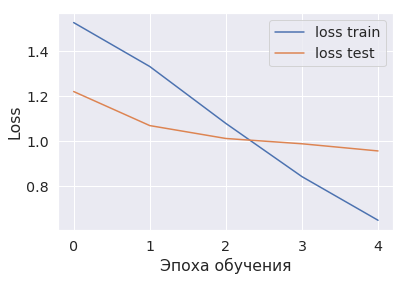

In [143]:
plt.plot(loaded_history_json['loss'], 
         label='loss train')
plt.plot(loaded_history_json['val_loss'], 
         label='loss test')
plt.xlabel('Эпоха обучения')
plt.ylabel('Loss')
plt.legend()
plt.show()

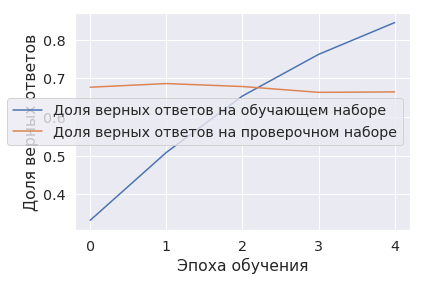

In [144]:
plt.plot(loaded_history_json['acc'], 
         label='acc train')
plt.plot(loaded_history_json['val_acc'], 
         label='acc test')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [0]:
K.clear_session()

In [0]:
loaded_model = Sequential() #?
loaded_model = load_model(task3_filepath + 'baseline_model3.hdf5')

In [173]:
y_predicted_scores = loaded_model.predict(x_test_tokenized)
y_predicted_scores[y_predicted_scores>=0.5] = 1
y_predicted_scores[y_predicted_scores<0.5] = 0

print('Classification report\n')
print(classification_report(y_test, y_predicted_scores))

Classification report

              precision    recall  f1-score   support

           0       0.65      0.30      0.41       830
           1       1.00      0.00      0.01       485
           2       0.40      0.07      0.12       888
           3       0.39      0.10      0.16      1660
           4       0.91      0.61      0.73      7675

   micro avg       0.85      0.45      0.59     11538
   macro avg       0.67      0.22      0.29     11538
weighted avg       0.78      0.45      0.55     11538
 samples avg       0.45      0.45      0.45     11538



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [0]:
reverse_y_test = np.argmax(y_test, axis=1)
reverse_y_pred = np.argmax(y_predicted_scores, axis=1)

Confusion matrix, without normalization
None


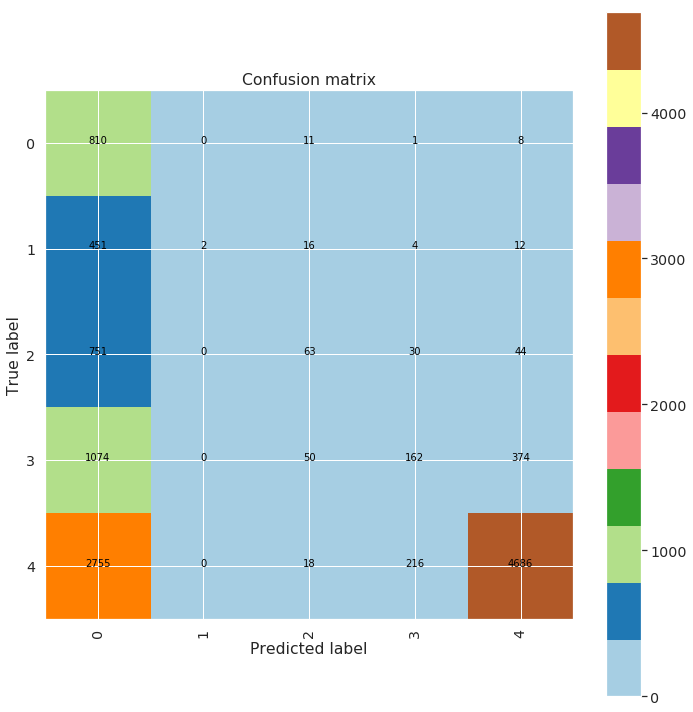

In [175]:
labels = [0,1,2,3,4]
cnf_matrix = confusion_matrix(reverse_y_test, reverse_y_pred)
print(plot_confusion_matrix(cnf_matrix, classes = labels))

В принципе, эта модель нейронной сети выглядит поинтереснее чем предыдущая, хоть у нее и f1-score будет поменьше.
В данном случае, количество выходных слоев embedding и количество max_features уменьшено в два раза (чтобы не падало с ошибкой окружение в колабе), но по результатам оказалось достаточно неплохо.

Судя по репорту, смущает больше всего precision у класса 1, при этом полнота = 0. Т.е. мы корректно предсказали 2 объекта, при этом пропустили все остальные...


#### Character based model.
Обучить сharacter based модель (вместо слов мы подаём предложение посимвольно).

In [0]:
K.clear_session()
del model, loaded_model

In [0]:
max_features = 40000
maxlen = 250
batch_size = 256
embedding_dims = 64
epochs = 5
task4_filepath = "drive/My Drive/data/models/subtask4/"

In [305]:
%%time
tokenizer = Tokenizer(
    char_level=True,
    #filters=None,
    lower=True,
    num_words=max_features
)

tokenizer.fit_on_texts(x_train)

x_train_tokenized = tokenizer.texts_to_sequences(x_train)
x_test_tokenized  = tokenizer.texts_to_sequences(x_test)

CPU times: user 7.9 s, sys: 36.9 ms, total: 7.94 s
Wall time: 7.95 s


In [306]:
print('Average train sequence length: {}'.format(
        np.mean(list(map(len, x_train_tokenized)), dtype=int)))
print('Average test sequence length: {}'.format(
        np.mean(list(map(len, x_test_tokenized)), dtype=int)))

Average train sequence length: 202
Average test sequence length: 195


In [307]:
%%time
x_train_tokenized = sequence.pad_sequences(x_train_tokenized, padding='post', maxlen=maxlen)
x_test_tokenized = sequence.pad_sequences(x_test_tokenized, padding='post', maxlen=maxlen)

CPU times: user 822 ms, sys: 49.2 ms, total: 871 ms
Wall time: 872 ms


In [308]:
x_train_tokenized.shape

(40253, 250)

In [309]:
x_test_tokenized.shape

(11538, 250)

In [310]:
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
print (vocab_size)

84


LTSM Shape note:
- Samples. One sequence is one sample. A batch is comprised of one or more samples.
- Time Steps. One time step is one point of observation in the sample.
- Features. One feature is one observation at a time step.

so, we have x_train_part.shape[0] samples, 1 time step and maxlen = x_train_part.shape[1] features.

In [0]:
'''x_train_part = np.reshape(x_train_part, (x_train_part.shape[0], 1,  x_train_part.shape[1]))
x_test_part = np.reshape(x_test_part, ( x_test_part.shape[0], 1,  x_test_part.shape[1]))

x_train_part.shape''';

В качестве примера имплементации была взята модель с каггла: 

https://www.kaggle.com/mamamot/character-based-lstm

и к ней добавлен входной embedding-layer.

Также для сравнения была взята bidirectional lstm из второй подзадачи.

In [312]:
# define model
model = Sequential()

model.add(Embedding(input_dim = vocab_size,
                    output_dim = embedding_dims,
                    input_length=maxlen, 
                    embeddings_initializer = 'glorot_uniform'))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(embedding_dims)))
model.add(Dropout(0.5))
model.add(Dense(5, activation="softmax"))


'''model.add(Embedding(input_dim = vocab_size,
                    output_dim = embedding_dims,
                    input_length=maxlen, 
                    embeddings_initializer = 'glorot_uniform')) 
model.add(BatchNormalization())
#model.add(LSTM(128, input_shape=(x_train_part.shape[1], x_train_part.shape[2]), activation="tanh", return_sequences=True))
model.add(LSTM(128, input_shape=(maxlen, max_features), activation="tanh", return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(LSTM(64, input_shape=(500, 25000), activation="tanh", return_sequences=False))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(100, activation="tanh"))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(50, activation="tanh"))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(5, activation="softmax"))''';#backup



earlyStopping = EarlyStopping(monitor='val_acc', patience=2, verbose=2, mode='max',restore_best_weights=True)
model.compile(loss='categorical_crossentropy',
              #optimizer = sgd,
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 64)           5376      
_________________________________________________________________
batch_normalization_1 (Batch (None, 250, 64)           256       
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 72,325
Trainable params: 72,197
Non-trainable params: 128
_________________________________________________________________


In [0]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=3, 
                              verbose=1, min_delta=0.01,
                              mode='min',restore_best_weights=True)


checkpoint = ModelCheckpoint(task4_filepath + 'baseline_model4.hdf5', monitor='val_acc', 
                             verbose=1, save_best_only=True, mode='max')

m_callbacks = [checkpoint, earlyStopping]

In [314]:
history_model = model.fit(x_train_tokenized, y_train,
          batch_size=batch_size,
          epochs=epochs, #epochs
          verbose = 1,
          callbacks=m_callbacks,
          validation_data=(x_test_tokenized, y_test))

Train on 40253 samples, validate on 11538 samples
Epoch 1/5
40253/40253 [==============================] - 317s 8ms/step - loss: 1.5685 - acc: 0.2912 - val_loss: 1.3833 - val_acc: 0.5534

Epoch 00001: val_acc improved from -inf to 0.55339, saving model to drive/My Drive/data/models/subtask4/baseline_model4.hdf5
Epoch 2/5
40253/40253 [==============================] - 312s 8ms/step - loss: 1.5284 - acc: 0.3217 - val_loss: 1.3911 - val_acc: 0.4739

Epoch 00002: val_acc did not improve from 0.55339
Epoch 3/5
40253/40253 [==============================] - 314s 8ms/step - loss: 1.5001 - acc: 0.3389 - val_loss: 1.2727 - val_acc: 0.5656

Epoch 00003: val_acc improved from 0.55339 to 0.56561, saving model to drive/My Drive/data/models/subtask4/baseline_model4.hdf5
Epoch 4/5
40253/40253 [==============================] - 311s 8ms/step - loss: 1.4687 - acc: 0.3615 - val_loss: 1.2242 - val_acc: 0.5418

Epoch 00004: val_acc did not improve from 0.56561
Epoch 5/5
40253/40253 [======================

In [0]:
'''# serialize model to JSON
model_json = model.to_json()
with open(path + "model" + ".json", "w") as json_file:
    json_file.write(model_json)
''';
with open(task4_filepath + "history4"+ ".json", 'w') as f:
    json.dump(history_model.history, f)
'''    
# serialize weights to HDF5
model.save_weights(path + "model" +  ".h5")
print("Saved model to disk")''';

In [0]:
#load history
json_file = open(task4_filepath + "history4"+ ".json", 'r')
loaded_history_json = json.load(json_file)
json_file.close()

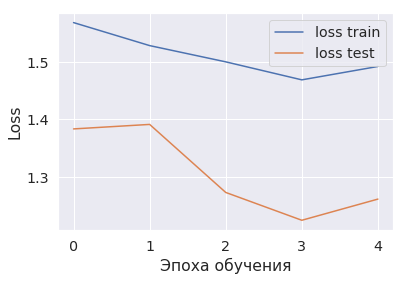

In [317]:
plt.plot(loaded_history_json['loss'], 
         label='loss train')
plt.plot(loaded_history_json['val_loss'], 
         label='loss test')
plt.xlabel('Эпоха обучения')
plt.ylabel('Loss')
plt.legend()
plt.show()

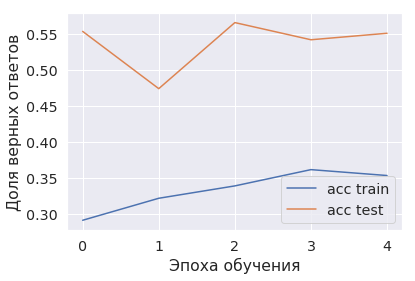

In [320]:
plt.plot(loaded_history_json['acc'], 
         label='acc train')
plt.plot(loaded_history_json['val_acc'], 
         label='acc test')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [0]:
loaded_model = Sequential() #?
loaded_model = load_model(task4_filepath + 'baseline_model4.hdf5')

In [0]:
y_predicted_scores = loaded_model.predict(x_test_tokenized)

In [323]:
y_predicted_scores[y_predicted_scores>=0.5] = 1
y_predicted_scores[y_predicted_scores<0.5] = 0

print('Classification report\n')
print(classification_report(y_test, y_predicted_scores))

Classification report

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       830
           1       0.00      0.00      0.00       485
           2       0.00      0.00      0.00       888
           3       0.00      0.00      0.00      1660
           4       0.90      0.17      0.29      7675

   micro avg       0.90      0.11      0.20     11538
   macro avg       0.18      0.03      0.06     11538
weighted avg       0.60      0.11      0.19     11538
 samples avg       0.11      0.11      0.11     11538



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


Для этой задачи буквенная модель не является оптимальной, т.к. входные данные - тексты отзывов, состоящие из двух алфавитов + с отсеченной пунктуацией, по сути состоят из одних и тех же символов и поэтому здесь не получается четкой классификации.

P.s. сравнение производилось на нескольких моделях (вторая - закоменнтирована, но её бекап был предварительно сделан, суть результатов схожая).

Возможно использовав иную преодбработку данных (не убирать пунктуацию, попробовать поработать с частицами), то  - негативные отзывы, за счет большего обилия пунктуации, удасться лучше распознавать.

#### Conclusions.

На небольшом объеме данных лучше всего показала себя логистическая регрессия, модели lstm и "fasstext" показали результаты несколько хуже.

Исходя из результатов, если дообучить fasstext на бОльших объемах данных + изменить гиперпаратры num_features, embedding_dims, то она скорее всего покажет наилучшие результаты.

Символьная модель показала наихудший результаты, в силу того, что эта задача не является подходящей для этой структруы нейросети.

#### Word2Vec.

Обучить модель из примера имплементации, но с использованием уже предобученного word2vec для русского языка в качестве инициализации эмбединга.

Так, как mystem не работает в колабе (но работает на локальной машине) https://github.com/nlpub/pymystem3/issues/28

, то удалось придти к  следующему pipeline:

- препроцессим тексты при помощи mystem для приведения их к одному виду с преодобученным word2vec
- составляем embedding layer, используя уже предобученный word2vec
- обучаем нейросеть.

Но, на шаге 1 в колабе возникли проблемы + либа для препроцессинга достаточно медленная (1-2 секунды на текст), поэтому продолжу эксперимент с bpemb/fasttext.

https://nlp.h-its.org/bpemb/ru/



In [0]:
mapping_url = 'https://raw.githubusercontent.com/akutuzov/universal-pos-tags/4653e8a9154e93fe2f417c7fdb7a357b7d6ce333/ru-rnc.map'

mystem2upos = {}
r = requests.get(mapping_url, stream=True)
for pair in r.text.split('\n'):
    pair = pair.split()
    if len(pair) > 1:
        mystem2upos[pair[0]] = pair[1]

In [247]:
mystem2upos

{'A': 'ADJ',
 'ADV': 'ADV',
 'ADVPRO': 'ADV',
 'ANUM': 'ADJ',
 'APRO': 'DET',
 'COM': 'ADJ',
 'CONJ': 'SCONJ',
 'INTJ': 'INTJ',
 'NONLEX': 'X',
 'NUM': 'NUM',
 'PART': 'PART',
 'PR': 'ADP',
 'S': 'NOUN',
 'SPRO': 'PRON',
 'UNKN': 'X',
 'V': 'VERB'}

In [0]:
class Preprocessor:
    def __init__(self, mapping):
        self.m = Mystem()
        self.mapping = mapping
        
    def process(self, text, postags=True):
      processed = self.m.analyze(text)
      tagged = []
      for w in processed:
        try:
          lemma = w["analysis"][0]["lex"].lower().strip()
          pos = w["analysis"][0]["gr"].split(',')[0]
          pos = pos.split('=')[0].strip()
          pos = self.mapping.get(pos, 'X')
          tagged.append(lemma.lower() + '_' + pos)
        except KeyError:
          continue
        except IndexError:
          continue
        if not postags:
          tagged = [t.split('_')[0] for t in tagged]
        return tagged

phrases_processor = Preprocessor(mystem2upos)

In [237]:
x_train[1]

'вчера приобрела очень понравился шее особенно нравится делать'

In [0]:
phrases_processor.process(x_train[1])

In [0]:
'''def preprocess_test(text,n_start, n_end):
    print (text[0])
    prepocessed_texts = []
    for sub_text in text[n_start:n_end]:
        prepocessed_texts.append(phrases_processor.process(text))
    return prepocessed_texts''';
        

In [0]:
prepocessed_train_texts = []
i= 0
for text in tqdm(x_train):
  i+=1
  prepocessed_train_texts.append(phrases_processor.process(text))
'''  if i==10:
    break'''

In [0]:
prepocessed_texts_test = []
i= 0
for text in tqdm(x_test):
  i+=1
  prepocessed_texts_test.append(phrases_processor.process(text))
'''  if i==10:
    break'''


  3%|██▌                                                                          | 135/4000 [03:36<1:39:49,  1.55s/it]


  7%|█████▏                                                                       | 271/4000 [07:22<1:59:18,  1.92s/it]


 10%|███████▊                                                                     | 407/4000 [11:13<1:45:46,  1.77s/it]


 14%|██████████▍                                                                  | 543/4000 [14:54<1:22:45,  1.44s/it]


 17%|█████████████                                                                | 679/4000 [18:34<1:26:49,  1.57s/it]


 20%|███████████████▋                                                             | 816/4000 [22:03<1:17:20,  1.46s/it]


 24%|██████████████████▎                                                          | 952/4000 [25:30<1:17:10,  1.52s/it]


 25%|███████████████████▏                                                         | 999/4000 [26:43<1:17:37,  1.55s/it]

In [0]:
path_word2vec = "drive/My Drive/data/models/word2vec/"
with open(path_word2vec + 'prepocessed_train_texts.pkl', 'wb') as fp:
    pickle.dump(prepocessed_train_texts, fp)

with open(path_word2vec + 'prepocessed_texts_test.pkl', 'wb') as fp:
    pickle.dump(prepocessed_texts, fp)

In [0]:
cwd = os.getcwd()

model_path = cwd + '\\models\\word2vec\\ruwikiruscorpora-nobigrams_upos_skipgram_300_5_2018.vec.gz'
model = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=False)

In [0]:
#model.most_similar('платить_VERB')
#word_vector = model['платить_VERB']
#word_vector.shape

In [0]:
#model.most_similar('платить_VERB')
#word_vector = model['платить_VERB']
#word_vector.shape
model.most_similar('игра_NOUN')

[('играмм_NOUN', 0.6844817399978638),
 ('игругой_NOUN', 0.6661473512649536),
 ('игра_PROPN', 0.6560357809066772),
 ('игре_VERB', 0.6470746994018555),
 ('игр_NOUN', 0.6220640540122986),
 ('видеоигра_NOUN', 0.6018214225769043),
 ('dishonored_PROPN', 0.5930976867675781),
 ('littlebigplanet_PROPN', 0.5877217054367065),
 ("mirror's_PROPN", 0.5868256688117981),
 ('moba_PROPN', 0.5865598320960999)]

In [0]:
word_vector = model['и']
word_vector.shape

In [0]:
%%time
tokenizer = Tokenizer(num_words=max_features)

tokenizer.fit_on_texts(prepocessed_texts)

x_train_tokenized = tokenizer.texts_to_sequences(prepocessed_texts)
x_test_tokenized  = tokenizer.texts_to_sequences(prepocessed_texts_test)

Wall time: 97.3 ms


In [0]:
%%time
x_train_tokenized = sequence.pad_sequences(x_train_tokenized, padding='post', maxlen=maxlen)
x_test_tokenized = sequence.pad_sequences(x_test_tokenized, padding='post', maxlen=maxlen)

Wall time: 22.9 ms


In [0]:
max_features = 5000
maxlen = 100
MAX_SEQUENCE_LENGTH = 100
word_index = tokenizer.word_index
EMBEDDING_DIM = 64

In [0]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    try:
        embedding_vector = model[word]
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    except KeyError: #for case when words not found
        continue

In [0]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [0]:
# REWORK IT!

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(35)(x)  # global max pooling
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(5, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

# happy learning!
model.fit(x_train, y_train, validation_data=(x_test, y_test),
          epochs=2, batch_size=32)